# Ejercicio 1

Tomar un texto en inglés y calcular la frecuencia de palabras.

# Ejercicio 2

Eliminar las "stopwords" y realizar "stemming" a mi conjunto de datos.

# Ejercicio 3

Realizar un análisis de sentimiento a mi conjunto de datos.

### Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import re

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist  # Para calcular frecuencia de palabras
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
from itertools import islice # Para habilitar islice en dataframes pandas.
from matplotlib.patches import FancyArrowPatch  # Para especificar comportamiento de flechas.
from adjustText import adjust_text  # Para ajustar de forma automática texto en gráficas (no es la panacea, pero ayuda)

import requests  # Para descargar URL

In [2]:
# Descarga de datos necesaria para que funcione nltk (solo se hace la primera vez)
# nltk.download('all')

Selecciono un texto clásico de la literatura, una famosa obra de teatro de Shakespeare: la tragedia Romeo y Julieta. Titulada en inglés como "Romeo and Juliet", fue publicada por primera vez en 1597. Al parecer Shakespeare se inspiró fuertemente en relatos de Matteo Bandello, un fraila Dominico y un popular escritor de relatos breves en el siglo XVI.

### Carga y limpieza inicial de datos

In [3]:
# URL del fichero (sacado del "Gutenberg Project")
url_romeo_and_juliet = "https://www.gutenberg.org/cache/epub/1513/pg1513.txt"

# Enviar request a la URL
response = requests.get(url_romeo_and_juliet)

# ¿Tiene éxito o no?
if response.status_code == 200:
    # Loading the content of the file into a variable
    romeo_and_juliet = response.text
    print("File loaded successfully!")
    # You can now proceed with sentiment analysis on text_content
    # For example, using text_content with nltk, TextBlob, or any other library
else:
    print(f"Failed to load the file. Status code: {response.status_code}")

File loaded successfully!


In [4]:
# print(romeo_and_juliet)

Hay que eliminar una serie de texto técnico-legal de la página web que "ensucia" el texto de cara al análisis. Así que eliminamos ese texto, que se encuentra antes y después de las líneas "*** START OF THE PROJECT GUTENBERG EBOOK ROMEO AND JULIET ***" y "*** END OF THE PROJECT GUTENBERG EBOOK ROMEO AND JULIET ***".

In [5]:
# Example markers
start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK ROMEO AND JULIET ***"
end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK ROMEO AND JULIET ***"

# Finding the indices of the start and end markers
start_index = romeo_and_juliet.find(start_marker)
end_index = romeo_and_juliet.find(end_marker)

# Adjusting the start_index to the end of the start marker
if start_index != -1:
    start_index += len(start_marker)

# Slicing the text to keep only the content between the start and end markers
if start_index != -1 and end_index != -1:
    romeo_and_juliet_cleaned = romeo_and_juliet[start_index:end_index]
else:
    romeo_and_juliet_cleaned = romeo_and_juliet # If markers are not found, keep the original text

# Now 'content' contains only the text between the specified markers


In [6]:
# romeo_and_juliet_cleaned

In [7]:
# Aquí se homogeneiza el formato "NOMBRE.\n" que no siempre se cumplía en el texto.

# Insert a newline between character names and their dialogue
character_dialogue_pattern = re.compile(r'([A-Z][A-Z\s\’]*\.) (?=[A-Z])')
romeo_and_juliet_normalized = character_dialogue_pattern.sub(r'\1\n', romeo_and_juliet_cleaned)

# Aquí substituimos múltiples caracteres de nueva línea por uno solo.
normalized_text = re.sub(r'\r\n?', '\n', romeo_and_juliet_normalized)
normalized_text = re.sub(r'\n{2,}', '\n', normalized_text)

# Las "acciones" van entre corchetes, pero algunas abarcan varias líneas. Hay que consolidarlas en una sola línea para que se detecten bien.
multi_line_action_pattern = re.compile(r'\[\_(.*?)\_\]', re.DOTALL)
normalized_text = multi_line_action_pattern.sub(lambda x: ' '.join(x.group().split()), normalized_text)


In [8]:
type(normalized_text)

str

In [9]:
len(normalized_text)

141359

Obtenemos un objeto FreqDist a partir de las palabras tokenizadas en minúscula:

In [10]:
tokens_all = word_tokenize(normalized_text.lower())

# Calculate frequencies
freq_dist_all = FreqDist(tokens_all)

freq_dist_all


FreqDist({',': 2704, '.': 2435, '’': 867, 'and': 733, 'the': 687, 'i': 641, 'to': 543, 'a': 483, 'of': 395, '?': 369, ...})

In [11]:
# Top 20 "palabras" o elementos contabilizados, como dataframe:
df_all_freqs = pd.DataFrame(list(freq_dist_all.items()), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).reset_index().head(20)
df_all_freqs

,index,Word,Frequency
0,43,",",2704
1,11,.,2435
2,25,’,867
3,4,and,733
4,0,the,687
5,13,i,641
6,41,to,543
7,16,a,483
8,2,of,395
9,274,?,369


Vemos cómo antes de eliminar stopwords y otros elementos (como signos de puntuación) los elementos más frecuentes son, justamente puntuación (coma, punto, comilla), y luego partículas "vacías de sentido" (and, the, i, to, etc). Es por eso que hay que eliminar todos estos elementos superfluos que impiden una correcta interpretación de cuáles son las ideas, conceptos o elementos que más se repiten en el texto.

Veamos cómo cambia la lista si eliminamos todos estos elementos.

Definimos una función que filtrará las "stopwords", incluyendo algunas que son características de textos arcaicos que en inglés reciente equivaldrían a partículas como "the", "them", etc.

In [14]:
def tokenizacion_lematizacion(text):
    # Tokenizar el texto
    tokens = word_tokenize(text.lower())
    # Especificar lo que sigue, que es necesario debido al lenguaje antiguo de la obra.
    stopwords_arcaicos = ['thou', 'thy', 'thee', 'thine', 'ye', 'thine']
    
    # Eliminar "stop words" y puntuación ("token.isalpha()" indica que queremos texto/tokens sin puntuación)
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english') and token.isalpha() and token not in stopwords_arcaicos]

    # Lematizar los "tokens" (llevarlos a su "raiz" idiomática, por así decir)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Volver a fusionar los tokens en forma de string
    processed_text = ' '.join(lemmatized_tokens)

    return processed_text

Contaje de palabras del texto normalizado y lematizado:

In [15]:
normalized_lemmatized_text = tokenizacion_lematizacion(normalized_text)

# Calculate frequencies
tokens = word_tokenize(normalized_lemmatized_text.lower())
freq_dist = FreqDist(tokens)
freq_dist

FreqDist({'romeo': 313, 'juliet': 188, 'capulet': 163, 'love': 151, 'nurse': 143, 'lady': 122, 'come': 121, 'shall': 110, 'friar': 104, 'mercutio': 88, ...})

Como antes, hemos obtenido un objeto "FreqDist" que contiene la información de la frecuencia de las palabras. Ya vemos que el resultado es muy diferente, pero representémoslo gráficamente antes de comentarlo:

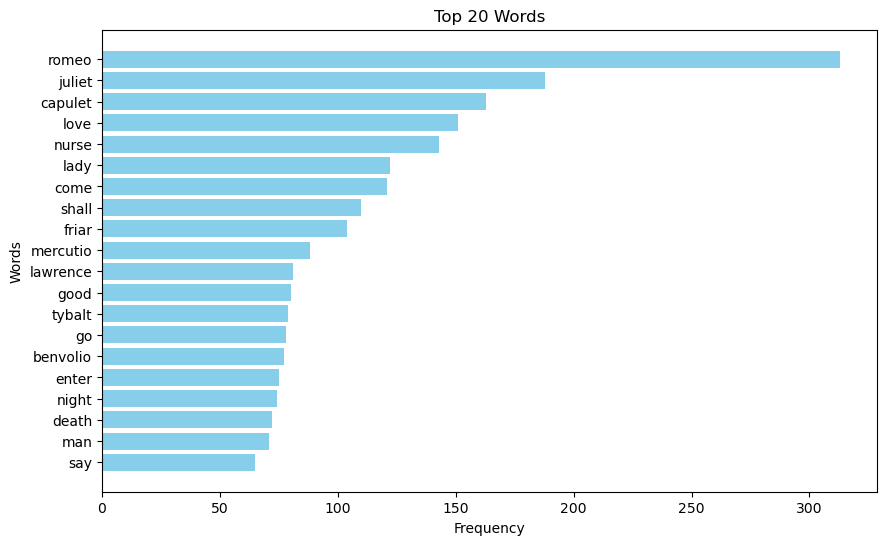

In [17]:
# Get the top 20 words and their frequencies
top_words = freq_dist.most_common(20)    # Método del objeto FreqDist que nos da el "top veinte".

# Extract words and frequencies
words, frequencies = zip(*top_words)  # Extraemos de dos en dos palabra y frecuencia.

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.barh(words, frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Words')

# Show the plot
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest frequency word at the top
plt.show()

Observamos como muchas de las palabras más frecuentes son en realidad nombres de personajes. Dado que Romeo y Julieta son los protagonistas, es lógico que sean los personajes má mencionados. También como personajes le siguen Capuleto, Mercutio, Lawrence, etc. como reflejo de sus más secundarios papeles en la obra.

En cuanto a conceptos, es muy lógico que la palabra "amor", "love", sea la más citada, en total más de 150 veces, ya que es el tema centra de la obra. Le siguen cargos y oficios como "nurse", "lady", "friar"... o acciones como "come", "shall", "go", "say"... y otros términos "good", "night", "death", "man".... que aparecen entre 150 y 50 veces, según el caso.

### Análisis de sentimiento

A continuación haremos el análisis de sentimiento, pero trataremos de extraer el texto de cada personaje para ver qué personajes son más positivos y cuáles menos, en cuanto al texto que recitan.

In [18]:
# Recuperamos el texto normalizado pero aún no lematizado:
#normalized_text

Establecemos una serie de patrones que nos permitirán distinguir si está hablando un personaje (y cuál) o bien si estamos en el inicio de acto o se está describiendo algo en el texto.

In [19]:
lines = normalized_text.split('\n')

# Expresiones regulares que capturarán personajes, El inicio de las escenas, o la descripción de acciones
character_pattern = re.compile(r'^[A-Z][A-Z\s\’]*(?=\.)')
scene_pattern = re.compile(r'^(ACT|SCENE)\s.*', re.I)
action_pattern = re.compile(r'\[\_(.*?)\_\]')  # Refined to match actions with underscores
# Consider adding a pattern for broader scene descriptions or prologues if needed

script_content = {'dialogue': {}, 'actions': [], 'scenes': []}

# Los personajes tienen varias líneas, esta variable controla quién habla, si es que es un personaje.
current_character = None

for line in lines:
    if scene_pattern.match(line) or line.startswith("SCENE."):
        # Handle scene descriptions more broadly
        current_scene = line.strip()
        script_content['scenes'].append(current_scene)
        current_character = None
    elif character_pattern.match(line):
        current_character = line[:-1]
        script_content['dialogue'].setdefault(current_character, [])
    elif action_pattern.findall(line):
        # Extract actions
        actions = action_pattern.findall(line)
        script_content['actions'].extend([f'[_{action}_]' for action in actions])
        line = action_pattern.sub('', line).strip()
    elif current_character:
        # Add to dialogue if there's a current character, and the line is not just a scene description
        if line.strip() and not line.strip().startswith("SCENE."):
            script_content['dialogue'][current_character].append(line)

# Después de lo anterior tendremos el texto de todos los personajes en "scritp_content['dialogue']".
            
print("Scenes:", len(script_content['scenes']))
print("Actions:", len(script_content['actions']))
print("Characters speaking:", len(script_content['dialogue']))


Scenes: 59
Actions: 124
Characters speaking: 34


Trabajaremos con el diálogo solamente, comprobamos qué personajes ha recogido nuestro procesado:

In [20]:
script_content['dialogue'].keys()

dict_keys(['THE PROLOGUE', 'CHORUS', 'SAMPSON', 'GREGORY', 'ABRAM', 'BENVOLIO', 'TYBALT', 'FIRST CITIZEN', 'CAPULET', 'LADY CAPULET', 'MONTAGUE', 'LADY MONTAGUE', 'PRINCE', 'ROMEO', 'PARIS', 'SERVANT', 'NURSE', 'JULIET', 'MERCUTIO', 'FIRST SERVANT', 'SECOND SERVANT', 'CAPULET’S COUSIN', 'FRIAR LAWRENCE', 'PETER', 'FIRST MUSICIAN', 'SECOND MUSICIAN', 'THIRD MUSICIAN', 'BALTHASAR', 'APOTHECARY', 'FRIAR JOHN', 'PAGE', 'FIRST WATCH', 'SECOND WATCH', 'THIRD WATCH'])

In [21]:
# Se ha colado un no-personaje; lo elimino:
del script_content['dialogue']['THE PROLOGUE']

In [22]:
script_content['dialogue']

{'CHORUS': ['Three Musicians.',
  'An Officer.',
  'Citizens of Verona; several Men and Women, relations to both houses;',
  'Maskers, Guards, Watchmen and Attendants.',
  'Two households, both alike in dignity,',
  'In fair Verona, where we lay our scene,',
  'From ancient grudge break to new mutiny,',
  'Where civil blood makes civil hands unclean.',
  'From forth the fatal loins of these two foes',
  'A pair of star-cross’d lovers take their life;',
  'Whose misadventur’d piteous overthrows',
  'Doth with their death bury their parents’ strife.',
  'The fearful passage of their death-mark’d love,',
  'And the continuance of their parents’ rage,',
  'Which, but their children’s end, nought could remove,',
  'Is now the two hours’ traffic of our stage;',
  'The which, if you with patient ears attend,',
  'What here shall miss, our toil shall strive to mend.',
  'Now old desire doth in his deathbed lie,',
  'And young affection gapes to be his heir;',
  'That fair for which love groan’

Recogeremos el texto en un dataframe, asignándolo a cada personaje según corresponda.

In [23]:
# Prepare data for DataFrame
data = []

# Process dialogues
for character, lines in script_content['dialogue'].items():
    for line in lines:
        data.append({'text': line, 'character': character})

# Create DataFrame
romeo_and_juliet_df = pd.DataFrame(data)

romeo_and_juliet_df

,text,character
0,Three Musicians.,CHORUS
1,An Officer.,CHORUS
2,"Citizens of Verona; several Men and Women, rel...",CHORUS
3,"Maskers, Guards, Watchmen and Attendants.",CHORUS
4,"Two households, both alike in dignity,",CHORUS
...,...,...
3052,These dead men’s tombs.,FIRST WATCH
3053,Here’s Romeo’s man. We found him in the church...,SECOND WATCH
3054,"Here is a Friar that trembles, sighs, and weeps.",THIRD WATCH
3055,We took this mattock and this spade from him,THIRD WATCH


In [24]:
romeo_and_juliet_df['processed_text'] = romeo_and_juliet_df['text'].apply(tokenizacion_lematizacion)

romeo_and_juliet_df

,text,character,processed_text
0,Three Musicians.,CHORUS,three musician
1,An Officer.,CHORUS,officer
2,"Citizens of Verona; several Men and Women, rel...",CHORUS,citizen verona several men woman relation house
3,"Maskers, Guards, Watchmen and Attendants.",CHORUS,masker guard watchman attendant
4,"Two households, both alike in dignity,",CHORUS,two household alike dignity
...,...,...,...
3052,These dead men’s tombs.,FIRST WATCH,dead men tomb
3053,Here’s Romeo’s man. We found him in the church...,SECOND WATCH,romeo man found churchyard
3054,"Here is a Friar that trembles, sighs, and weeps.",THIRD WATCH,friar tremble sigh weeps
3055,We took this mattock and this spade from him,THIRD WATCH,took mattock spade


In [25]:
# initialize NLTK sentiment analyzer

analyzer = SentimentIntensityAnalyzer()


# create get_sentiment function

def get_sentiment(text):

    scores = analyzer.polarity_scores(text)

    sentiment = 1 if scores['pos'] > 0 else 0

    return sentiment

In [26]:
# apply get_sentiment function

romeo_and_juliet_df['sentiment'] = romeo_and_juliet_df['processed_text'].apply(get_sentiment)

romeo_and_juliet_df

,text,character,processed_text,sentiment
0,Three Musicians.,CHORUS,three musician,0
1,An Officer.,CHORUS,officer,0
2,"Citizens of Verona; several Men and Women, rel...",CHORUS,citizen verona several men woman relation house,0
3,"Maskers, Guards, Watchmen and Attendants.",CHORUS,masker guard watchman attendant,0
4,"Two households, both alike in dignity,",CHORUS,two household alike dignity,1
...,...,...,...,...
3052,These dead men’s tombs.,FIRST WATCH,dead men tomb,0
3053,Here’s Romeo’s man. We found him in the church...,SECOND WATCH,romeo man found churchyard,0
3054,"Here is a Friar that trembles, sighs, and weeps.",THIRD WATCH,friar tremble sigh weeps,1
3055,We took this mattock and this spade from him,THIRD WATCH,took mattock spade,0


In [27]:
# Agrupar según personaje y calcular el sentimiento promedio
average_sentiment_per_character = romeo_and_juliet_df.groupby('character')['sentiment'].mean().reset_index()

# Print the result
average_sentiment_per_character.head()

,character,sentiment
0,ABRAM,0.200000
1,APOTHECARY,0.428571
2,BALTHASAR,0.187500
3,BENVOLIO,0.291139
4,CAPULET,0.360000


Ya hemos obtenido el cálculo del sentimiento, pero no todos los personajes tienen la misma importancia.

In [28]:
# Función lambda para contar las palabras mediante un "apply()"
romeo_and_juliet_df['word_count'] = romeo_and_juliet_df['processed_text'].apply(lambda x: len(x.split()))

# Agrupar por personaje y de modo que tengamos el sentimiento promedio y el número de palabras que hemos calculado
average_sentiment_per_character = romeo_and_juliet_df.groupby('character').agg({'sentiment': 'mean', 'word_count': 'sum'}).reset_index()

# Renombrar columnas
average_sentiment_per_character.rename(columns={'sentiment': 'mean_sentiment', 'word_count': 'total_word_count'}, inplace=True)

print(average_sentiment_per_character.head())

    character  mean_sentiment  total_word_count
0       ABRAM        0.200000                13
1  APOTHECARY        0.428571                20
2   BALTHASAR        0.187500               104
3    BENVOLIO        0.291139               594
4     CAPULET        0.360000              1053


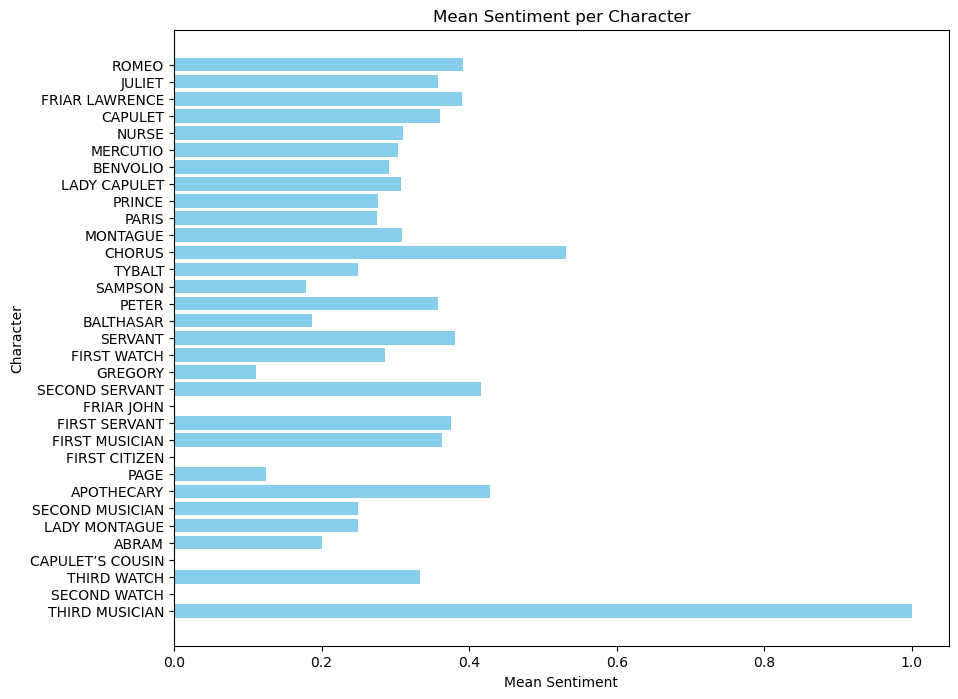

In [29]:
# Ordenar en orden descendiente de número de palabras
average_sentiment_per_character = average_sentiment_per_character.sort_values(by='total_word_count', ascending=False)

# Extraer datos del dataframe
characters = average_sentiment_per_character['character']
mean_sentiment = average_sentiment_per_character['mean_sentiment']

# Barplot horizontal
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

# Orden del eje "y", indicando seguir el orden del dataframe
plt.barh(range(len(characters)), mean_sentiment, color='skyblue')
# Especificar "ticks" y orden
plt.yticks(range(len(characters)), characters)

plt.xlabel('Mean Sentiment')
plt.ylabel('Character')
plt.title('Mean Sentiment per Character')

# Optionally, add this line to invert the y-axis and have the highest values at the top
plt.gca().invert_yaxis()

plt.show()


Como es de esperar, Romeo y Julieta son protagonistas, seguidos por el Fraile Lawrence y Capuleto y la enfermera. Es de destacar que el sentimiento promedio de todos los personajes principales es moderado o bajo. Solo el coro se desmarca, con un tono por encima de 0,5, y el personaje con menos texto, el "Tercer Músico", que se percibe como netamente positivo.

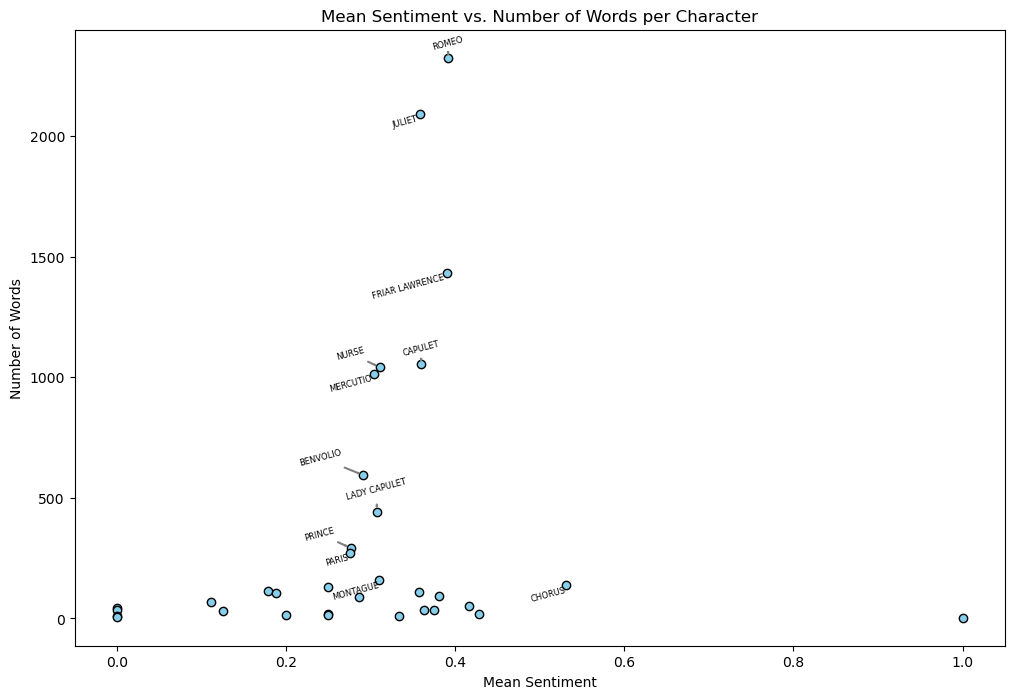

In [30]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(average_sentiment_per_character['mean_sentiment'], average_sentiment_per_character['total_word_count'], color='skyblue', edgecolor='black')

texts = []
ax = plt.gca()

# Annotate points with character names
for i, row in islice(average_sentiment_per_character.iterrows(), 12):
    text = plt.text(row['mean_sentiment'], row['total_word_count'], row['character'], fontsize=6, ha='right', rotation=15)
    texts.append(text)

# Optimize text placement with adjust_text
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

# Re-calculate arrow positions after text adjustment if necessary
# This is conceptual; in practice, you would need to manually adjust or use a different strategy
# for dynamic arrow drawing post-adjustment.

plt.xlabel('Mean Sentiment')
plt.ylabel('Number of Words')
plt.title('Mean Sentiment vs. Number of Words per Character')

plt.show()


En este "scatter plot" vemos lo mismo, desde otra perspectiva. Aquí queda mucho más claro que hay aproximadamente una decena de personajes más importantes que los demás, y que en general se caracterizan en cuanto a sentimiento por ser más bien negativo, o sea por debajo de 0,5.

Los múltiples otros personajes que son meras comparsas, secundarios o cuasi-figurantes no contribuyen tampoco según nuestras métricas a elevar la positividad de la obra (una tragedia, después de todo), añadiendo más tiniebla al conjunto.

Solo el coro y uno de los músicos (el punto que se desmarca a la derecha) muestra un tono algo más positivo, en el caso del "tercer músico", como si fuese ajeno al drama que se desarrolla en la obra.


Cabe añadir un último matiz: el lenguaje de esta obra es antiguo, arcaico, y es posible que esto represente una dificultad adicional para la correcta detección. No obstante, como no disponemos de un "benchmark" con el que contrastar ello, lo dejamos en este punto.